## 1. 任务介绍
> 介绍任务的基本内容，以及问题的公式化
---
文本分类是自然语言处理中最基础的任务之一，主要是通过分类器将给定的文本划分到特定的类，比如情绪分类、垃圾邮件分类、电影评论分类等。具体任务公式化如下：
$$
\begin{aligned}
文本 ： &X = (x_1,x_2,\dots,x_n) \\
类标签 ：& Y = (y_1,y_2,\dots,y_n)\\
模型 ：& f: x_i  \xrightarrow{f} y_i, \hspace{1em} i = 1,2, \dots,n
\end{aligned}
$$
本文选用Kaggle的电影评论情感分析来作为任务。

## 2.环境准备

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 

import nltk
from nltk.corpus import stopwords

N_CLASSES = 2 # 类别数

## 3. 数据预处理
> 需要对数据进行清洗
---

处理步骤大致如下：
    1. 去除html标签
    2. 去除标点
    3. 切分成词
    4. 去除停用词
    5. 重组为新的句子

In [2]:
# 0. 先准备数据
file_path = '../data/IMDB/labeledTrainData.tsv'
df = pd.read_csv(file_path,sep='\t',escapechar='\\')
print('Number of samples:{}'.format(len(df)))
df.head()

Number of samples:25000


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
eng_stopwords = stopwords.words('english') #定义停用词

def text_clean(text):
    text = BeautifulSoup(text,'html.parser').get_text() #去除html标签
    text = re.sub(r'[^a-zA-Z]',' ',text) #去除标点
    words = text.lower().split()  #全部转成小写，然后按空格分词
    words = [w for w in words if w not in eng_stopwords] #去除停用词
    return ' '.join(words)  #重组成新的句子

df['clean_review'] = df.review.apply(text_clean)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...


## 4. 文本特征表示 
> 文本向量化，并提取特征，分为离散法和分布式法(此处主要讲离散法)
---
离散法主要有以下几种方法：
 1. 词袋模型(Bag of word): 用单词频数来表示文本，不考虑文本的语法结构和单词顺序
 2. 独热编码(One-hot): 将文本表示成整个词标长度的向量，出现过的词为1，否则为0
 3. n元语法(n-gram): 对词袋模型的一种改进，即用n个词或词组组成的字符串作为特征，然后再用词袋模型的方法将文本表示为向量形式
 4. TF-IDF： 用词的TF-IDF来表示文本
 
<span style="color:red">注：其实上述方法都可以看作是词袋模型</span>

In [4]:
# 1. 使用统计词频，作为文本特征
vectorizer_feq = CountVectorizer(max_features=5000) #取词频为前5000的词
data_freq = vectorizer_feq.fit_transform(df.clean_review).toarray()
print("词频为特征的文本-单词矩阵维度:",data_freq.shape)

# 2. 使用bigram，作为文本特征
vectorizer_bigram = CountVectorizer(ngram_range=(2,2),max_features=1000,token_pattern=r'\b\w+\b', min_df=1)
# analyze = vectorizer_bigram.build_analyzer()
# print("bi-gram示例：",analyze(df.clean_review[0]))#bi-gram举例
data_bigram = vectorizer_bigram.fit_transform(df.clean_review).toarray()
print("bi-gram为特征的文本-单词矩阵维度：",data_bigram.shape)

# 2. 使用tfidf, 作为文本特征
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
data_tfidf = vectorizer_tfidf.fit_transform(df.clean_review).toarray()

print("TF-IDF为特征的文本-单词矩阵维度：",data_tfidf.shape)

词频为特征的文本-单词矩阵维度: (25000, 5000)
bi-gram为特征的文本-单词矩阵维度： (25000, 1000)
TF-IDF为特征的文本-单词矩阵维度： (25000, 5000)


## 5. 辅助函数
> 包括数据批量生成器，softmax函数，预测函数，评估函数

In [5]:
# 定义数据批量生成器
def batch_generator(data, batch_size, shuffle=True):
    X, Y = data
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)  # 打乱顺序

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]


# softmax函数
def softmax(scores):
    sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
    softmax = np.exp(scores) / sum_exp
    return softmax

# 预测函数
def predict(w,x):
    scores = np.dot(x, w.T)
    probs = softmax(scores)

    return np.argmax(probs, axis=1).reshape(-1, 1)

# 评估函数
def evaluate(y_true,y_pred):
    precision = metrics.precision_score(y_true,y_pred)
    recall = metrics.recall_score(y_true,y_pred)
    f1_score = metrics.f1_score(y_true,y_pred)

    return precision,recall,f1_score


# 将数据集分割
def split_data(x, y, val_split=0.2):
    n_samples = x.shape[0]

    indices = np.random.permutation(n_samples)
    split = int(n_samples * (1 - val_split))
    training_idx = indices[:split]
    valid_idx = indices[split:]

    train_x = x[training_idx]
    train_y = y[training_idx]

    valid_x = x[valid_idx]
    valid_y = y[valid_idx]

    return train_x, train_y, valid_x, valid_y

## 6. 构建分类器
> 此处以softmax regression作为分类器

In [6]:
def valid(w, val_x, val_y, batch_size):
    val_loss = []
    val_gen = batch_generator((val_x, val_y), batch_size, shuffle=False)

    for batch_x, batch_y in val_gen:
        scores = np.dot(batch_x, w.T)
        prob = softmax(scores)

        y_one_hot = np.eye(N_CLASSES)[batch_y]
        # 损失函数
        loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
        val_loss.append(loss)

    return np.mean(val_loss)


def train(train_x,
          train_y,
          valid_x,
          valid_y,
          lr=0.1,
          batch_size=128,
          epochs=500,
          early_stop=None):

    n_features = train_x.shape[1]
    w = np.random.rand(N_CLASSES, n_features)

    train_all_loss = []
    val_all_loss = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    not_improved = 0
    best_val_loss = np.inf
    best_w = None

    for epoch in range(epochs):
        training_gen = batch_generator((train_x, train_y), batch_size)
        train_loss = []
        for batch_x, batch_y in training_gen:
            scores = np.dot(batch_x, w.T)
            prob = softmax(scores)

            y_one_hot = np.eye(N_CLASSES)[batch_y]
            # 损失函数
            loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
            train_loss.append(loss)

            # 梯度下降
            dw = -(1.0 / len(batch_x)) * np.dot((y_one_hot - prob).T, batch_x)
            w = w - lr * dw
            
        val_loss = valid(w, valid_x, valid_y, batch_size)


        val_precision, val_recall, val_f1_score = evaluate(
            valid_y, predict(w, valid_x))

        print(
            "Epoch = {0},the train loss = {1:.4f}, the val loss = {2:.4f}, precision={3:.4f}%, recall={4:.4f}%, f1_score={4:.4f}%"
            .format(epoch, np.mean(train_loss), val_loss, val_precision * 100,
                    val_recall * 100, val_f1_score * 100))

        train_all_loss.append(np.mean(train_loss))
        val_all_loss.append(val_loss)
        precision_list.append(val_precision)
        recall_list.append(val_recall)
        f1_score_list.append(val_f1_score)

        if early_stop is not None:
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                best_w = w
                not_improved = 0
            else:
                not_improved += 1

            if not_improved > early_stop:
                print("Validation performance didn\'t improve for {} epochs. "
                      "Training stops.".format(early_stop))
                break

    return best_w, train_all_loss, val_all_loss,precision_list,recall_list,f1_score_list

## 7.训练 

### 7.1 以BOW为特征进行训练 

In [7]:
label = df['sentiment'].values

train_x, trian_y, val_x, val_y = split_data(data_tfidf, label)

w, train_all_loss, val_all_loss, precision_list, recall_list, f1_score_list = train(train_x,
                                                 trian_y,
                                                 val_x,
                                                 val_y,
                                                 early_stop=10)

Epoch = 0,the train loss = 0.7096, the val loss = 0.7100, precision=51.0152%, recall=41.0539%, f1_score=41.0539%
Epoch = 1,the train loss = 0.6975, the val loss = 0.6984, precision=53.9225%, recall=44.3627%, f1_score=44.3627%
Epoch = 2,the train loss = 0.6860, the val loss = 0.6874, precision=56.2530%, recall=47.2222%, f1_score=47.2222%
Epoch = 3,the train loss = 0.6750, the val loss = 0.6769, precision=58.9303%, recall=50.4085%, f1_score=50.4085%
Epoch = 4,the train loss = 0.6643, the val loss = 0.6669, precision=61.1372%, recall=53.1454%, f1_score=53.1454%
Epoch = 5,the train loss = 0.6542, the val loss = 0.6575, precision=63.0009%, recall=55.2288%, f1_score=55.2288%
Epoch = 6,the train loss = 0.6447, the val loss = 0.6485, precision=64.3848%, recall=56.8627%, f1_score=56.8627%
Epoch = 7,the train loss = 0.6357, the val loss = 0.6398, precision=65.8759%, recall=58.9869%, f1_score=58.9869%
Epoch = 8,the train loss = 0.6274, the val loss = 0.6316, precision=66.8310%, recall=60.9069%, f

Epoch = 72,the train loss = 0.4054, the val loss = 0.4252, precision=82.9603%, recall=86.3154%, f1_score=86.3154%
Epoch = 73,the train loss = 0.4044, the val loss = 0.4239, precision=83.0255%, recall=86.3154%, f1_score=86.3154%
Epoch = 74,the train loss = 0.4037, the val loss = 0.4226, precision=82.9603%, recall=86.3154%, f1_score=86.3154%
Epoch = 75,the train loss = 0.4013, the val loss = 0.4214, precision=83.0063%, recall=86.3971%, f1_score=86.3971%
Epoch = 76,the train loss = 0.4001, the val loss = 0.4202, precision=83.0848%, recall=86.4788%, f1_score=86.4788%
Epoch = 77,the train loss = 0.3987, the val loss = 0.4190, precision=83.1240%, recall=86.5196%, f1_score=86.5196%
Epoch = 78,the train loss = 0.3973, the val loss = 0.4178, precision=83.2809%, recall=86.4788%, f1_score=86.4788%
Epoch = 79,the train loss = 0.3956, the val loss = 0.4166, precision=83.3268%, recall=86.5605%, f1_score=86.5605%
Epoch = 80,the train loss = 0.3944, the val loss = 0.4155, precision=83.3661%, recall=86

Epoch = 144,the train loss = 0.3393, the val loss = 0.3676, precision=85.1072%, recall=87.5408%, f1_score=87.5408%
Epoch = 145,the train loss = 0.3384, the val loss = 0.3671, precision=85.1469%, recall=87.5817%, f1_score=87.5817%
Epoch = 146,the train loss = 0.3383, the val loss = 0.3666, precision=85.1469%, recall=87.5817%, f1_score=87.5817%
Epoch = 147,the train loss = 0.3378, the val loss = 0.3662, precision=85.1410%, recall=87.5408%, f1_score=87.5408%
Epoch = 148,the train loss = 0.3369, the val loss = 0.3657, precision=85.1072%, recall=87.5408%, f1_score=87.5408%
Epoch = 149,the train loss = 0.3368, the val loss = 0.3652, precision=85.1072%, recall=87.5408%, f1_score=87.5408%
Epoch = 150,the train loss = 0.3358, the val loss = 0.3647, precision=85.1131%, recall=87.5817%, f1_score=87.5817%
Epoch = 151,the train loss = 0.3353, the val loss = 0.3643, precision=85.1131%, recall=87.5817%, f1_score=87.5817%
Epoch = 152,the train loss = 0.3349, the val loss = 0.3638, precision=85.1131%, 

Epoch = 216,the train loss = 0.3066, the val loss = 0.3415, precision=85.9245%, recall=88.2761%, f1_score=88.2761%
Epoch = 217,the train loss = 0.3059, the val loss = 0.3413, precision=85.9245%, recall=88.2761%, f1_score=88.2761%
Epoch = 218,the train loss = 0.3058, the val loss = 0.3410, precision=85.9586%, recall=88.2761%, f1_score=88.2761%
Epoch = 219,the train loss = 0.3056, the val loss = 0.3407, precision=85.9642%, recall=88.3170%, f1_score=88.3170%
Epoch = 220,the train loss = 0.3051, the val loss = 0.3405, precision=85.9698%, recall=88.3578%, f1_score=88.3578%
Epoch = 221,the train loss = 0.3053, the val loss = 0.3402, precision=85.9698%, recall=88.3578%, f1_score=88.3578%
Epoch = 222,the train loss = 0.3044, the val loss = 0.3399, precision=85.9698%, recall=88.3578%, f1_score=88.3578%
Epoch = 223,the train loss = 0.3042, the val loss = 0.3397, precision=85.9698%, recall=88.3578%, f1_score=88.3578%
Epoch = 224,the train loss = 0.3036, the val loss = 0.3394, precision=85.9642%, 

Epoch = 288,the train loss = 0.2854, the val loss = 0.3263, precision=86.3727%, recall=88.8072%, f1_score=88.8072%
Epoch = 289,the train loss = 0.2856, the val loss = 0.3261, precision=86.4124%, recall=88.8480%, f1_score=88.8480%
Epoch = 290,the train loss = 0.2850, the val loss = 0.3260, precision=86.4124%, recall=88.8480%, f1_score=88.8480%
Epoch = 291,the train loss = 0.2851, the val loss = 0.3258, precision=86.4467%, recall=88.8480%, f1_score=88.8480%
Epoch = 292,the train loss = 0.2846, the val loss = 0.3256, precision=86.4811%, recall=88.8480%, f1_score=88.8480%
Epoch = 293,the train loss = 0.2844, the val loss = 0.3255, precision=86.4811%, recall=88.8480%, f1_score=88.8480%
Epoch = 294,the train loss = 0.2838, the val loss = 0.3253, precision=86.4811%, recall=88.8480%, f1_score=88.8480%
Epoch = 295,the train loss = 0.2840, the val loss = 0.3251, precision=86.4811%, recall=88.8480%, f1_score=88.8480%
Epoch = 296,the train loss = 0.2839, the val loss = 0.3250, precision=86.4811%, 

Epoch = 360,the train loss = 0.2706, the val loss = 0.3163, precision=86.7782%, recall=89.0114%, f1_score=89.0114%
Epoch = 361,the train loss = 0.2704, the val loss = 0.3162, precision=86.8127%, recall=89.0114%, f1_score=89.0114%
Epoch = 362,the train loss = 0.2710, the val loss = 0.3161, precision=86.8473%, recall=89.0114%, f1_score=89.0114%
Epoch = 363,the train loss = 0.2711, the val loss = 0.3160, precision=86.8473%, recall=89.0114%, f1_score=89.0114%
Epoch = 364,the train loss = 0.2700, the val loss = 0.3159, precision=86.8473%, recall=89.0114%, f1_score=89.0114%
Epoch = 365,the train loss = 0.2696, the val loss = 0.3157, precision=86.8421%, recall=88.9706%, f1_score=88.9706%
Epoch = 366,the train loss = 0.2693, the val loss = 0.3156, precision=86.8473%, recall=89.0114%, f1_score=89.0114%
Epoch = 367,the train loss = 0.2696, the val loss = 0.3155, precision=86.8820%, recall=89.0114%, f1_score=89.0114%
Epoch = 368,the train loss = 0.2695, the val loss = 0.3154, precision=86.8820%, 

Epoch = 432,the train loss = 0.2592, the val loss = 0.3093, precision=87.1200%, recall=88.9706%, f1_score=88.9706%
Epoch = 433,the train loss = 0.2595, the val loss = 0.3092, precision=87.1200%, recall=88.9706%, f1_score=88.9706%
Epoch = 434,the train loss = 0.2585, the val loss = 0.3091, precision=87.1200%, recall=88.9706%, f1_score=88.9706%
Epoch = 435,the train loss = 0.2588, the val loss = 0.3090, precision=87.1251%, recall=89.0114%, f1_score=89.0114%
Epoch = 436,the train loss = 0.2587, the val loss = 0.3089, precision=87.1251%, recall=89.0114%, f1_score=89.0114%
Epoch = 437,the train loss = 0.2584, the val loss = 0.3089, precision=87.0903%, recall=89.0114%, f1_score=89.0114%
Epoch = 438,the train loss = 0.2585, the val loss = 0.3088, precision=87.0903%, recall=89.0114%, f1_score=89.0114%
Epoch = 439,the train loss = 0.2583, the val loss = 0.3087, precision=87.1251%, recall=89.0114%, f1_score=89.0114%
Epoch = 440,the train loss = 0.2580, the val loss = 0.3086, precision=87.0903%, 

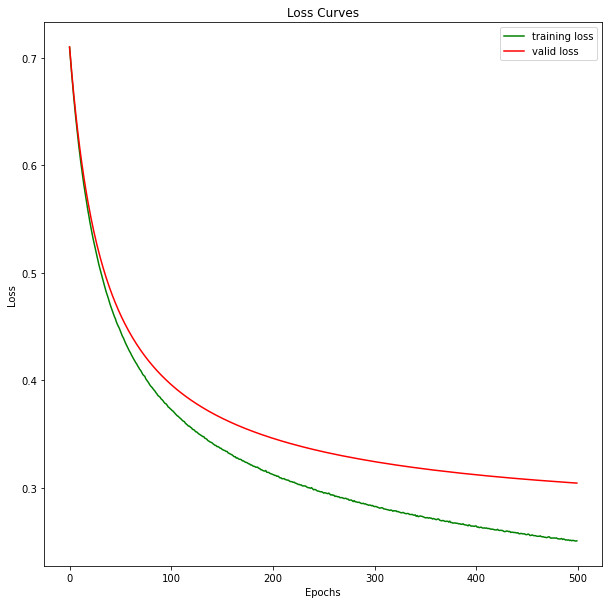

In [8]:
plt.figure(figsize=(10,10))
plt.title('Loss Curves')
plt.plot(
    np.arange(len(train_all_loss)),
              train_all_loss,
              color='green',
              label='training loss')
plt.plot(
    np.arange(len(val_all_loss)), val_all_loss, color='red',
              label='valid loss')
plt.legend()  # 显示图例

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

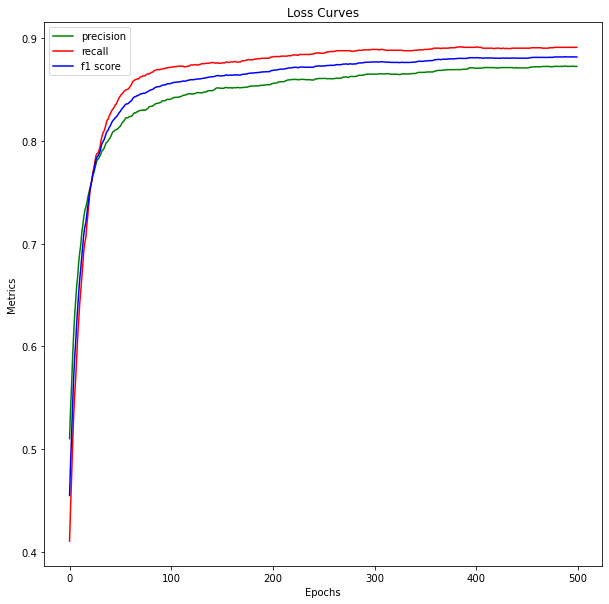

In [9]:
plt.figure(figsize=(10, 10))
plt.title('Loss Curves')
plt.plot(np.arange(len(precision_list)),
         precision_list,
         color='green',
         label='precision')
plt.plot(np.arange(len(recall_list)), recall_list, color='red', label='recall')

plt.plot(np.arange(len(f1_score_list)), f1_score_list, color='b', label='f1 score')
plt.legend()  # 显示图例

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

## 参考链接
https://www.cnblogs.com/Luv-GEM/p/10888026.html

https://zhuanlan.zhihu.com/p/98061179

https://github.com/FudanNLP/nlp-beginner/blob/master/%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB.md